In [1]:
%%time
import math
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
df = pd.read_pickle('../smoothed_folder/merged_smoothed_monthly_by_meternumber_consumerid_march032021.pck')
meta = pd.read_pickle('../metadata_folder/REG_metadata_March_3_2021.pck')
meta['meter_serial_number_consumer_id'] = meta['meter_serial_number'].astype(str)+'_'+meta['consumer_id']
meta1 = meta[meta.meter_serial_number_consumer_id.isin(meta.meter_serial_number_consumer_id[0:20000])]

def install_date(value):
    x = meta1[meta1['meter_serial_number_consumer_id']==
         value].installation_date.iloc[0]
    return x

CPU times: user 17.7 s, sys: 12.1 s, total: 29.8 s
Wall time: 20.3 s


In [2]:
%%time

# Filter x number of customers as a sample base 
df1 = df[df.meter_serial_number_consumer_id.isin(meta1.meter_serial_number_consumer_id.tolist())]

# convert transaction date column to datetime
df1['trans_period'] = pd.to_datetime(df1[['year','month']].assign(day= lambda x: x['month'].apply(
    lambda y: 31 if y in    [1,3,5,7,8,10,12] else (30 if y in [4,6,9,11] else (28 if y==2 else np.nan)))))
df1 = df1[['meter_serial_number_consumer_id','trans_period','kWhs']]
df1['connection_date'] = df1.apply(lambda x: install_date(x['meter_serial_number_consumer_id']), axis=1)
df1['months_since_connection'] = round((df1['trans_period'] - 
    df1['connection_date']).dt.days / 30, 0).astype(int) # compute months since connection
df1 = df1.sort_values(by=['meter_serial_number_consumer_id','trans_period'])

/home/jmugyenyi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


CPU times: user 38min 43s, sys: 7.6 s, total: 38min 51s
Wall time: 38min 47s


In [3]:
df1.meter_serial_number_consumer_id.nunique()

18584

In [4]:
%%time
df2 = df1.groupby('meter_serial_number_consumer_id').agg({ 
    'months_since_connection': lambda x: list(x),'kWhs': lambda x: list(x)}) # group by customer numbers
df2

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.28 s


,months_since_connection,kWhs
meter_serial_number_consumer_id,,
1026227601_102654,"[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5...","[47.29999999999999, 34.699999999999996, 34.699..."
1026227932_102988,"[0, 1, 2, 3]","[5.478260869565217, 15.660869565217384, 15.252..."
1026227973_100122,"[43, 44, 45, 46, 47]","[48.20000000000002, 42.400000000000006, 22.100..."
1026228278_109388,"[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...","[31.549999999999997, 50.55, 22.1, 26.85, 30.04..."
1026232973_11260,"[142, 143, 144, 145, 146, 147, 148, 149, 150, ...","[60.10000000000001, 61.575000000000024, 68.025..."
...,...,...
94100254054_10182,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[1.5, 46.09999999999998, 63.150000000000006, 3..."
94100254666_109266,"[114, 115, 116, 117, 118, 119, 120, 121, 122, ...","[8.2, 46.70000000000002, 25.400000000000006, 5..."
94100262701_103920,"[116, 118, 118, 120, 120, 122, 123, 124, 125, ...","[3.5749999999999993, 3.0249999999999995, 2.199..."


In [5]:
%%time
customer_list = [] # customer timeseries consumption data
customer_nos = [] # customer numbers
for i in range(len(df2)):
    # create dataframe of an individual customer's consumption
    x = pd.DataFrame(list(zip(df2.iloc[i][0], df2.iloc[i][1])), columns =['months_since_connection', 'kWhs'])
#     if (x.iloc[0][0]!=0): # check if consumption starts from the zeroth month
#         # add consumption for zeroth month if absent
#         x = pd.concat([pd.DataFrame({'months_since_connection':0, 'kWhs':np.nan,},
#                                                                 index =[0]), x]).reset_index(drop = True)
#         x.interpolate(limit_direction="both",inplace=True)
    x.set_index('months_since_connection', inplace=True) # set new dataframe index
    y = df2.index[i]
    customer_list.append(x)
    customer_nos.append(y)

CPU times: user 22 s, sys: 81.9 ms, total: 22.1 s
Wall time: 22.1 s


In [6]:
%%time
# Normalise each time series 
for i in range(len(customer_list)):
    scaler = MinMaxScaler()
    customer_list[i] = MinMaxScaler().fit_transform(customer_list[i])
    customer_list[i]= customer_list[i].reshape(len(customer_list[i]))
series_lengths = {len(series) for series in customer_list}
customer_list = to_time_series_dataset(customer_list).reshape((len(df2), max(series_lengths))) # format time series to same length

CPU times: user 52.6 s, sys: 195 ms, total: 52.8 s
Wall time: 52.6 s


In [7]:
%%time
# model
cluster_count = 3
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", max_iter=25, n_jobs=16, max_iter_barycenter=50)
labels = km.fit_predict(customer_list)
label_df = pd.DataFrame(labels, columns = ['labels'])
label_df.insert(0, "customer_no", customer_nos, True)

CPU times: user 1h 17min 45s, sys: 2min 15s, total: 1h 20min
Wall time: 1h 10min 30s


In [ ]:
%%time
# model
cluster_count = 3
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", max_iter=25, n_jobs=16, max_iter_barycenter=50)
labels = km.fit_predict(customer_list)
label_df = pd.DataFrame(labels, columns = ['labels'])
label_df.insert(0, "customer_no", customer_nos, True)

In [33]:
processed_df = pd.DataFrame(customer_nos, columns=['meter_serial_number_consumer_id'])
processed_df.reset_index(inplace=True)
processed_df = processed_df.rename(columns = {'index':'num'})
processed_df['monthly_consumption'] = processed_df.apply(lambda row: (customer_list[row.num]), axis = 1)
processed_df.drop(['num'], axis=1, inplace=True)
processed_df

,meter_serial_number_consumer_id,monthly_consumption
0,1026227601_102654,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,1026227932_102988,"[0.0, 0.7608836907082526, 0.7303443794671873, ..."
2,1026227973_100122,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,1026233161_101370,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,1026234763_10595,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...
9281,94100241143_103928,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
9282,94100250573_101503,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
9283,94100254054_10182,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
9284,94100262701_103920,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [23]:
processed_df.to_pickle("../temp_files/consumption_295months.pck")

In [22]:
len(processed_df.monthly_consumption[0])

295

In [35]:
len(labels)

9286

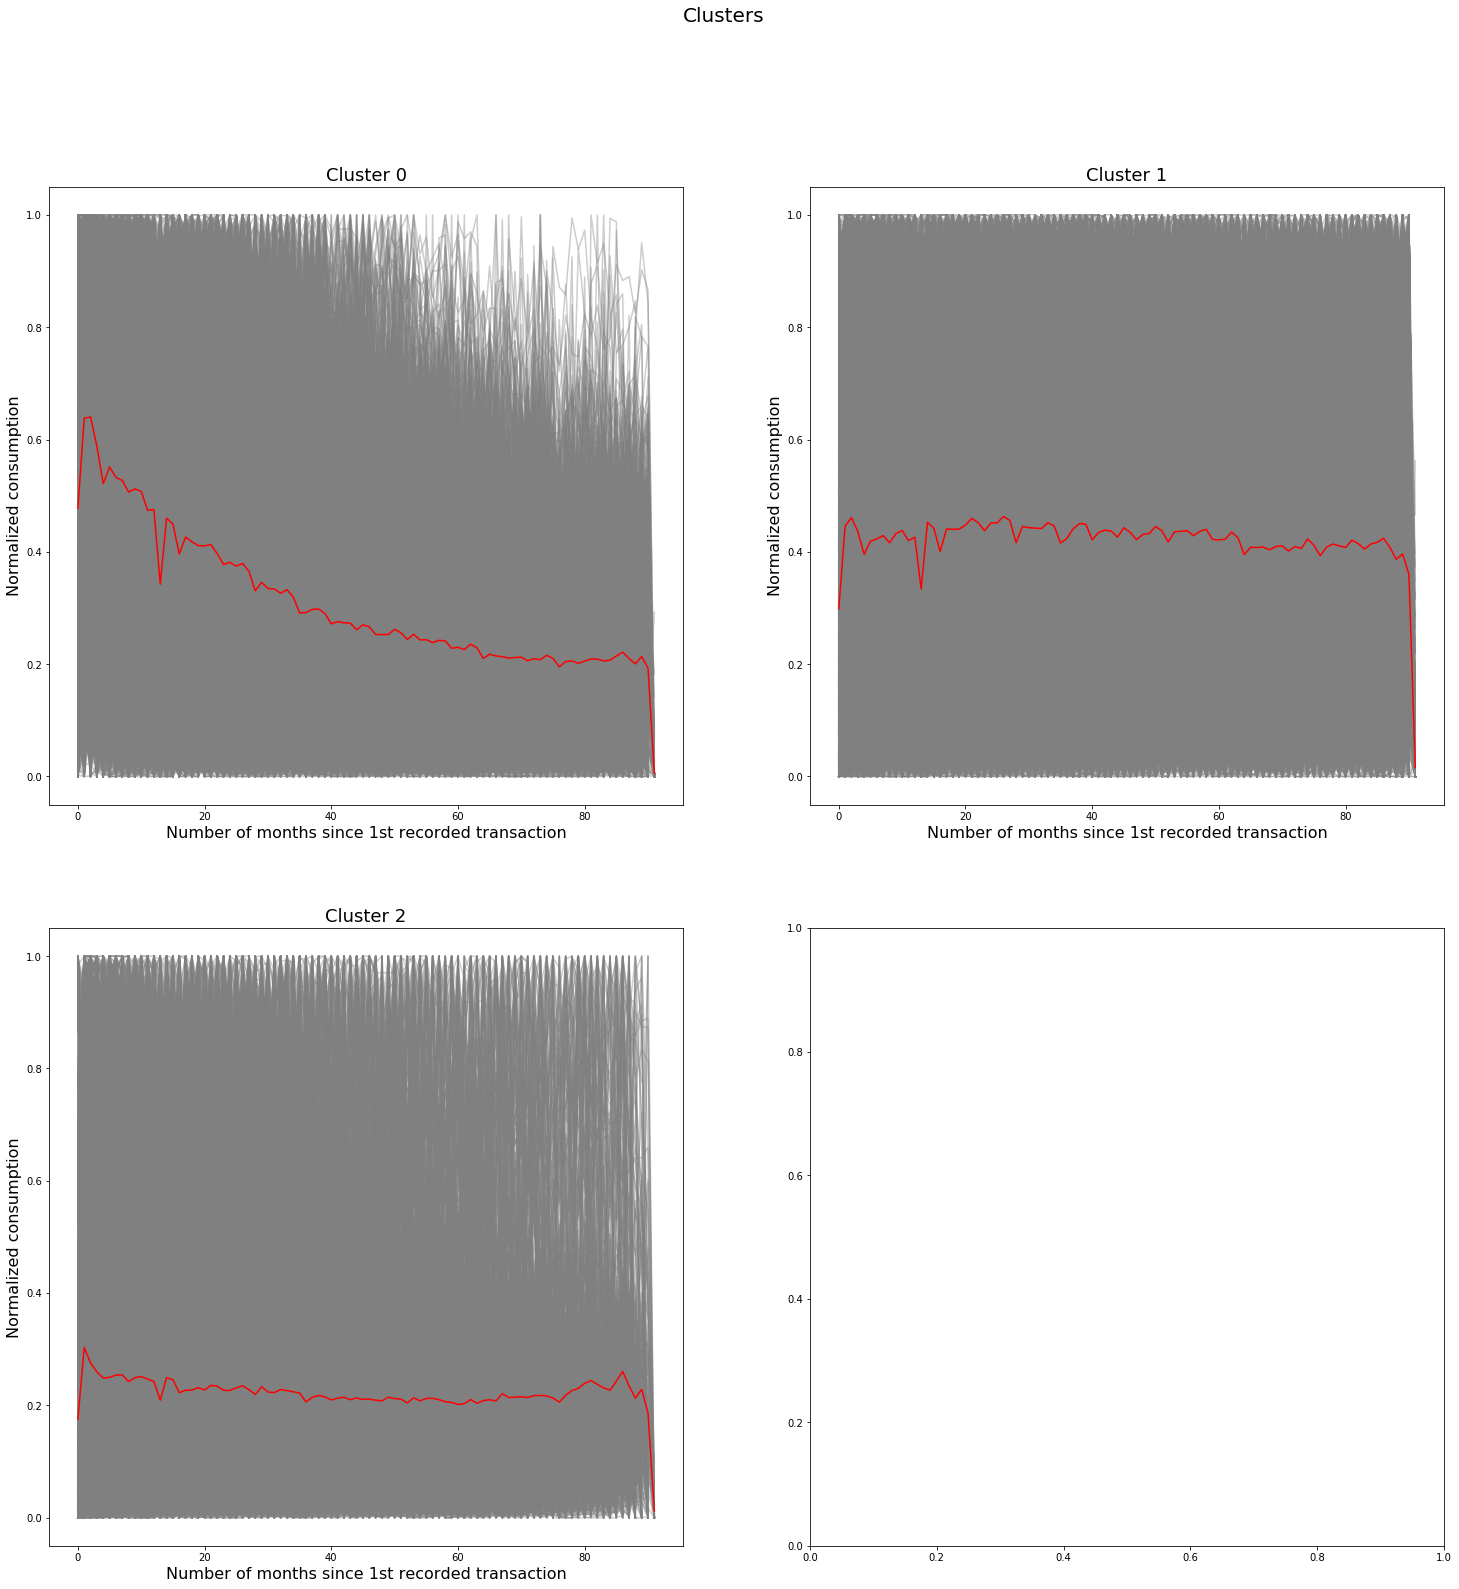

CPU times: user 1min 51s, sys: 658 ms, total: 1min 52s
Wall time: 1min 51s


In [8]:
%%time
import matplotlib.pyplot as plt
plot_count = math.ceil(math.sqrt(4))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters', fontsize=20)
row_i=0
column_j=0
plot_counter=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(customer_list[i],c="gray",alpha=0.4)
                axs[row_i, column_j].set_xlabel('Number of months since 1st recorded transaction', fontsize=16)
                axs[row_i, column_j].set_ylabel('Normalized consumption', fontsize=16)
                cluster.append(customer_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.nanmean(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title(f"Cluster {plot_counter}", fontsize=18)
    
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
    plot_counter+=1 
#     cluster_customers = label_df[label_df['labels']==label]['customer_no'].tolist()
#     stats = ts[ts.index.isin(cluster_customers)].average_consumption.describe()
#     f = open("cluster_stats.txt", "a")
#     f.write(f"Cluster: {label}\
#             \nCustomer count: {stats['count']}\
#             \nmean: {stats['mean']}\
#             \nmin: {stats['min']}\
#             \nmax: {stats['max']}\
#             \ncluster_customers: {cluster_customers}\n\n\n")
#     f.close()
# plt.savefig('clusters.png')
plt.show()

In [39]:
print(1)

1
